# PointPillars

Changes made based on [Major bugs](https://github.com/tyagi-iiitv/PointPillars/issues/27)

## Transformation operations

Made changes to `processors.py` to correct the transformation operations

```python
@staticmethod
def transform_labels_into_lidar_coordinates(labels: List[Label3D], R: np.ndarray, t: np.ndarray):
    transformed = []
    for label in labels:
        label.centroid = (label.centroid - t) @ np.linalg.inv(R).T       # corrected 
        label.dimension = label.dimension[[2, 1, 0]] # h w l => l ,w ,h
        label.yaw = -label.yaw   # the label.yaw is in the camera frame, 
        # in the lidar frame, the yaw is negative of label.yaw
        label.yaw -= np.pi / 2
```

In order to get the correct z-center coordinate of the bounding box, the following offset was added in lidar frame

```python
 label.centroid[2] += label.dimension[2] / 2   # the height

```

## Index for bestAnchor allocation


Made changes in `/src/point_pillars.cpp` 

```c++
td::tuple<pybind11::array_t<float>, int, int> createPillarsTarget(const pybind11::array_t<float>& objectPositions,
                                             const pybind11::array_t<float>& objectDimensions,
                                             const pybind11::array_t<float>& objectYaws,
                                             const pybind11::array_t<int>& objectClassIds,
                                             const pybind11::array_t<float>& anchorDimensions,
                                             const pybind11::array_t<float>& anchorZHeights,
                                             const pybind11::array_t<float>& anchorYaws,
                                             float positiveThreshold,
                                             float negativeThreshold,
                                             int nbClasses,
                                             int downscalingFactor,
                                             float xStep,
                                             float yStep,
                                             float xMin,
                                             float xMax,
                                             float yMin,
                                             float yMax,
                                             float zMin,
                                             float zMax,
                                             bool printTime = false)
{
 ...
        float maxIou = 0;
        BoundingBox3D bestAnchor = {};
        int bestAnchorId = 0;
        int bestAnchorXId = 0; # add variable
        int bestAnchorYId = 0; # add variable

        ...


                    if (maxIou < iouOverlap)
                    {
                        maxIou = iouOverlap;
                        bestAnchor = anchorBox;
                        bestAnchorId = anchorCount;
                        bestAnchorXId = xId;
                        bestAnchorYId = yId;
                    }
       ...
     if (maxIou < positiveThreshold) // Comparing maxIOU for that object obtained after 
                                     // checking with every anchor box
        // If none of the anchors passed the threshold, 
        // then we place the best anchor details for that object. 
        {
            negCnt++;

            const auto xId = bestAnchorXId;
            const auto yId = bestAnchorYId;
            ...
      }
       ...

```

#### IMPORTANT: The c++ code must be recompiled after each change. So re-run `python setup.py install`

## Loss function 


In `/src/point_pillars.cpp` when preparing targets in the function `createPillarsTarget`, the angle target was changed.

Old version:
```c++
tensor.mutable_at(objectCount, xId, yId, bestAnchorId, 7) = std::sin(labelBox.yaw - bestAnchor.yaw);
```
New version:
```c++
tensor.mutable_at(objectCount, xId, yId, bestAnchorId, 7) = labelBox.yaw - bestAnchor.yaw;
```

Changed to an updated version of the loss function in `loss_v2.py`, where we have an updated `angle_loss()`  function that uses `add_sin_difference()`

```python
def add_sin_difference(self, y_true, y_pred, factor=1.0):
    if factor != 1.0:
        y_true = factor * y_true
        y_pred = factor * y_pred
    rad_pred_encoding = tf.math.sin(y_pred) * tf.math.cos(y_true)
    rad_tg_encoding = tf.math.cos(y_pred) * tf.math.sin(y_true)
    return rad_tg_encoding, rad_pred_encoding
    
def angle_loss(self, y_true: tf.Tensor, y_pred: tf.Tensor):
    y_true, y_pred = self.add_sin_difference(y_true, y_pred)
    loss = tf.compat.v1.losses.huber_loss(y_true, y_pred, delta=3.0, reduction="none")

    masked_loss = tf.boolean_mask(loss, self.mask)
    return self.angle_weight * tf.reduce_mean(masked_loss)

```

## Bounding box yaw

Changed to an updated version of inference utils in `inference_utils_v2.py`, where
```python
bb_yaw = -np.arcsin(np.clip(ang[value], -1, 1)) + real_anchors[i][4]
```
was changed to
```python
bb_yaw = ang[value] + real_anchors[i][4]
```
 

In [ ]:
# ! python setup.py install

In [1]:
import os
import time
import numpy as np
from glob import glob
from config import Parameters
# from loss import PointPillarNetworkLoss
from loss_v2 import PointPillarNetworkLoss
from processors import SimpleDataGenerator
from readers import KittiDataReader
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# from inference_utils import generate_bboxes_from_pred, GroundTruthGenerator, focal_loss_checker, rotational_nms
from inference_utils_v2 import generate_bboxes_from_pred, GroundTruthGenerator, focal_loss_checker, rotational_nms


import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal


physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
K.clear_session()

def enable_amp():
    mixed_precision.set_global_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
print(physical_devices,"\n")
enable_amp()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/fixes.py:28: UserWarning: Module point_pillars was already imported from /usr/local/lib/python3.6/dist-packages/point_pillars-0.0.1-py3.6-linux-x86_64.egg/point_pillars.cpython-36m-x86_64-linux-gnu.so, but /tf/PythonProjects/object_detection/PointPillars is being added to sys.path
  from pkg_resources import parse_version  # type: ignore


Tensorflow version:  2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:
DATA_ROOT = "../kitti_dataset/training"  # TODO make main arg
MODEL_ROOT = "./logs"

In [3]:
def build_point_pillar_graph(params: Parameters):

    # extract required parameters
    max_pillars = int(params.max_pillars)
    max_points  = int(params.max_points_per_pillar)
    nb_features = int(params.nb_features)
    nb_channels = int(params.nb_channels)
    batch_size  = int(params.batch_size)
    image_size  = tuple([params.Xn, params.Yn])
    nb_classes  = int(params.nb_classes)
    nb_anchors  = len(params.anchor_dims)
    S1 = (1,1); S2 = (2,2); S3 = (3,3); S4 = (4,4)
    K1 = (1,1); K3 = (3,3)

    if K.image_data_format() == "channels_first":
        raise NotImplementedError
    else:
        input_shape = (max_pillars, max_points, nb_features)

    input_pillars = Input(input_shape, batch_size=batch_size, name="pillars/input")
    input_indices = Input((max_pillars, 3), batch_size=batch_size, name="pillars/indices", dtype=tf.int32)

    def correct_batch_indices(tensor, batch_size):
        array = np.zeros((batch_size, max_pillars, 3), dtype=np.float32)
        for i in range(batch_size):
            array[i, :, 0] = i
        return tensor + tf.constant(array, dtype=tf.int32)

    if batch_size > 1:
        corrected_indices = Lambda(lambda t: correct_batch_indices(t, batch_size))(input_indices)
    else:
        corrected_indices = input_indices

    # pillars
    x = Conv2D(nb_channels, (1, 1), activation='linear', use_bias=False, name="pillars/conv2d")(input_pillars)
    x = BatchNormalization(name="pillars/batchnorm", fused=True, epsilon=1e-3, momentum=0.99)(x)
    x = Activation("relu", name="pillars/relu")(x)
    x = MaxPool2D((1, max_points), name="pillars/maxpooling2d")(x)

    if K.image_data_format() == "channels_first":
        reshape_shape = (nb_channels, max_pillars)
    else:
        reshape_shape = (max_pillars, nb_channels)

    x = Reshape(reshape_shape, name="pillars/reshape")(x)
    pillars = Lambda(
        lambda inp: tf.scatter_nd(inp[0], inp[1],(batch_size,) + image_size + (nb_channels,)),
        name="pillars/scatter_nd"
    )([corrected_indices, x])

    # 2d cnn backbone

    # Block1(S, 4, C)
    x = pillars
    for n in range(4):
        S = (2, 2) if n == 0 else (1, 1)
        x = Conv2D(nb_channels,K3, strides=S, padding="same", activation="relu", name="cnn/block1/conv2d%i"%n)(x)
        x = BatchNormalization(name="cnn/block1/bn%i" % n, fused=True)(x)
    x1 = x

    # Block2(2S, 6, 2C)
    for n in range(6):
        S = (2, 2) if n == 0 else (1, 1)
        x = Conv2D(2*nb_channels,K3, strides=S, padding="same",activation="relu",name="cnn/block2/conv2d%i"%n)(x)
        x = BatchNormalization(name="cnn/block2/bn%i" % n, fused=True)(x)
    x2 = x

    # Block3(4S, 6, 4C)
    for n in range(6):
        S = (2, 2) if n == 0 else (1, 1)
        x = Conv2D(2*nb_channels,K3, strides=S, padding="same", activation="relu",name="cnn/block3/conv2d%i"%n)(x)
        x = BatchNormalization(name="cnn/block3/bn%i" % n, fused=True)(x)
    x3 = x

    # Up1 (S, S, 2C)
    up1 = Conv2DTranspose(2*nb_channels,K3,strides=S1,padding="same",activation="relu",name="cnn/up1/conv2dt")(x1)
    up1 = BatchNormalization(name="cnn/up1/bn", fused=True)(up1)

    # Up2 (2S, S, 2C)
    up2 = Conv2DTranspose(2*nb_channels,K3,strides=S2,padding="same",activation="relu",name="cnn/up2/conv2dt")(x2)
    up2 = BatchNormalization(name="cnn/up2/bn", fused=True)(up2)

    # Up3 (4S, S, 2C)
    up3 = Conv2DTranspose(2*nb_channels,K3,strides=S4,padding="same",activation="relu",name="cnn/up3/conv2dt")(x3)
    up3 = BatchNormalization(name="cnn/up3/bn", fused=True)(up3)

    # Concat
    concat = Concatenate(name="cnn/concatenate")([up1, up2, up3])

    # Detection head
    occ = Conv2D(nb_anchors, (1, 1), name="occupancy/conv2d", activation="sigmoid", dtype="float32")(concat)

    loc = Conv2D(nb_anchors*3, K1, name="loc/conv2d", kernel_initializer=TruncatedNormal(0, 0.001), dtype="float32")(concat)
    loc = Reshape(tuple(i//2 for i in image_size) + (nb_anchors, 3), name="loc/reshape", dtype="float32")(loc)

    size = Conv2D(nb_anchors*3, (1, 1), name="size/conv2d", kernel_initializer=TruncatedNormal(0, 0.001), dtype="float32")(concat)
    size = Reshape(tuple(i//2 for i in image_size) + (nb_anchors, 3), name="size/reshape", dtype="float32")(size)

    angle = Conv2D(nb_anchors, (1, 1), name="angle/conv2d", dtype="float32")(concat)

    heading = Conv2D(nb_anchors, (1, 1), name="heading/conv2d", activation="sigmoid", dtype="float32")(concat)

    clf = Conv2D(nb_anchors * nb_classes, (1, 1), name="clf/conv2d", dtype="float32")(concat)
    clf = Reshape(tuple(i//2 for i in image_size)+(nb_anchors,nb_classes),name="clf/reshape",dtype="float32")(clf)

    pillar_net = tf.keras.models.Model([input_pillars, input_indices], [occ, loc, size, angle, heading, clf])

    return pillar_net

In [4]:
params = Parameters()

In [5]:
pillar_net = build_point_pillar_graph(params)

In [6]:
# plot_model(pillar_net, show_shapes=True, dpi=100)

In [7]:
# pillar_net.load_weights(os.path.join(MODEL_ROOT, "model_v2.h5"))

In [8]:
loss = PointPillarNetworkLoss(params)

optimizer = Adam(lr=params.learning_rate, decay=params.decay_rate)

pillar_net.compile(optimizer, loss=loss.losses())

data_reader = KittiDataReader()

In [9]:
lidar_files = sorted(glob(os.path.join(DATA_ROOT, "velodyne", "*.bin")))
label_files = sorted(glob(os.path.join(DATA_ROOT, "label_2", "*.txt")))
calibration_files = sorted(glob(os.path.join(DATA_ROOT, "calib", "*.txt")))
validation_len = int(0.3*len(label_files))

In [10]:
training_gen = SimpleDataGenerator(
    data_reader, 
    params.batch_size, 
    lidar_files[:-validation_len], 
    label_files[:-validation_len], 
    calibration_files[:-validation_len]
)

validation_gen = SimpleDataGenerator(
    data_reader, 
    params.batch_size, 
    lidar_files[-validation_len:], 
    label_files[-validation_len:], 
    calibration_files[-validation_len:]
)

In [11]:
log_dir = MODEL_ROOT
ckpt_path = os.path.join(log_dir, "model_v3.h5")

epoch_to_decay = int(
    np.round(params.iters_to_decay/(params.batch_size*int(np.ceil(float(len(label_files)) /params.batch_size)))))

In [12]:
epoch_to_decay

14

In [13]:
callbacks = [
    ModelCheckpoint(filepath=ckpt_path, monitor='val_loss', save_best_only=True),
    LearningRateScheduler(
        lambda epoch, lr: lr * 0.8 if ((epoch % epoch_to_decay == 0) and (epoch != 0)) else lr, verbose=True),
    EarlyStopping(patience=20, monitor='val_loss'),
]

In [1]:
results = pillar_net.fit(
    training_gen,
    validation_data = validation_gen,
    steps_per_epoch=len(training_gen),
    callbacks=callbacks,
    use_multiprocessing=True,
    epochs=int(params.total_training_epochs),
    workers=8
)

In [ ]:
results = pillar_net.history

In [15]:
def plot_history(results):
    
    plt.figure(figsize=(16,8))
    
    plt.subplot(2,4,1)  
    plt.plot(results.history['loss'], 'r', label='Training')
    plt.plot(results.history['val_loss'], 'b', label='Validation')
    plt.title('Focal loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})

    plt.subplot(2,4,2)
    plt.plot(results.history['occupancy/conv2d_loss'], 'r', label='Training')
    plt.plot(results.history['val_occupancy/conv2d_loss'], 'b', label='Validation')
    plt.title('Occupancy loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})

    plt.subplot(2,4,3)
    plt.plot(results.history['loc/reshape_loss'], 'r', label='Training')
    plt.plot(results.history['val_loc/reshape_loss'], 'b', label='Validation')
    plt.title('Loc loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,4)
    plt.plot(results.history['size/reshape_loss'], 'r', label='Training')
    plt.plot(results.history['val_size/reshape_loss'], 'b', label='Validation')
    plt.title('Size loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,5)
    plt.plot(results.history['angle/conv2d_loss'], 'r', label='Training')
    plt.plot(results.history['val_angle/conv2d_loss'], 'b', label='Validation')
    plt.title('Angle loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,6)
    plt.plot(results.history['heading/conv2d_loss'], 'r', label='Training')
    plt.plot(results.history['val_heading/conv2d_loss'], 'b', label='Validation')
    plt.title('Heading loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,7)
    plt.plot(results.history['clf/reshape_loss'], 'r', label='Training')
    plt.plot(results.history['val_clf/reshape_loss'], 'b', label='Validation')
    plt.title('Clf loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,8)
    plt.plot(results.history['lr'], 'g')
    plt.title('Learning Rate', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0e'))
    
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.25, wspace=0.2)
    
    plt.show()

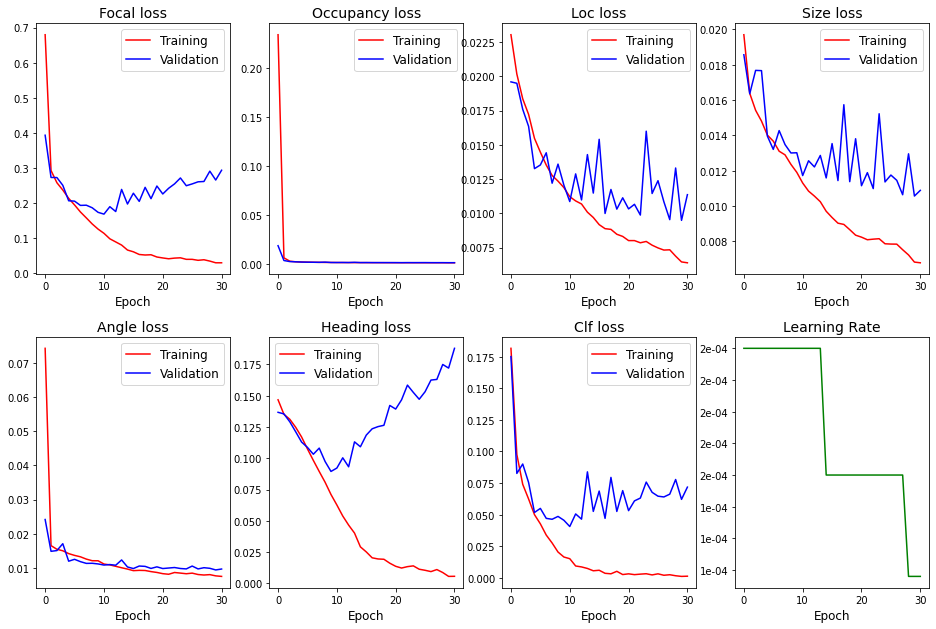

In [16]:
plot_history(results)

In [17]:
n_predictions = 200
eval_gen = SimpleDataGenerator(
    data_reader=data_reader, 
    batch_size=params.batch_size, 
    lidar_files=lidar_files[:n_predictions], 
    label_files=label_files[:n_predictions], 
    calibration_files=calibration_files[:n_predictions]
)

In [18]:
occupancy, position, size, angle, heading, classification = pillar_net.predict(
    eval_gen,
    batch_size=params.batch_size,
    verbose=1
)

50/50 [==============================] - 21s 416ms/step


In [2]:
set_boxes, confidences = [], []
loop_range = occupancy.shape[0] if len(occupancy.shape) == 4 else 1
for i in range(loop_range):
    bbox = generate_bboxes_from_pred(
        occupancy[i], 
        position[i], 
        size[i], 
        angle[i], 
        heading[i],
        classification[i], 
        params.anchor_dims, 
        occ_threshold=0.3
    )
    set_boxes.append(bbox)
    conf = [float(boxes.conf) for boxes in set_boxes[-1]]
    confidences.append(conf)
print('Scene 1: Box predictions with occupancy > occ_thr: ', len(set_boxes[0]))

NameError: name 'occupancy' is not defined

In [20]:
set_boxes[0:10]

[[],
 [],
 [],
 [((13.164220367296732, -0.8894786455844583),
   (4.062923018147956, 1.6229622129047243),
   4.123764277435633),
  ((13.283773173612655, -0.6113322667359539),
   (3.898335927684144, 1.57159864860175),
   4.274046368422486),
  ((13.185632359497433, -0.6982779949509703),
   (3.939740670699109, 1.5919383286228523),
   4.114882897080501),
  ((13.154756299690526, -0.6430001656428433),
   (3.8752695733221856, 1.571561741405155),
   3.4327866959474127),
  ((13.353216829430117, -0.8097319442779524),
   (4.129816096680372, 1.6343071227417454),
   5.768206598423427),
  ((13.393793326019486, -0.8198604776291651),
   (4.154955047643, 1.6616825351369755),
   5.634147060489002),
  ((13.30251656568298, -0.5339618360095539),
   (4.039806452832011, 1.6367855315921531),
   5.524307373351442),
  ((13.334564475923406, -0.6676981435248022),
   (4.081820468580304, 1.6376636749157854),
   6.4431539393730395),
  ((13.322343427485789, -0.6638372429304845),
   (4.169415337474902, 1.60760271560553

In [21]:
confidences[0:10]

[[],
 [],
 [],
 [0.3847087323665619,
  0.4408453106880188,
  0.34767183661460876,
  0.30997180938720703,
  0.33176127076148987,
  0.38778653740882874,
  0.4715583920478821,
  0.3665418326854706,
  0.3388371765613556,
  0.31949272751808167],
 [0.3164657950401306,
  0.3273134231567383,
  0.30728083848953247,
  0.403638631105423,
  0.4083114266395569,
  0.49380505084991455,
  0.30373987555503845,
  0.3188929557800293,
  0.3434103727340698,
  0.3016981780529022,
  0.3359898030757904,
  0.3404017686843872,
  0.3351708650588989,
  0.34976741671562195,
  0.3913676142692566,
  0.34025636315345764,
  0.32317206263542175],
 [0.3201391398906708, 0.3849838972091675],
 [0.30704763531684875,
  0.38699230551719666,
  0.40956056118011475,
  0.3860551118850708,
  0.38278067111968994,
  0.4397110939025879,
  0.47133535146713257,
  0.3001273274421692,
  0.320237934589386],
 [0.41318705677986145,
  0.5659839510917664,
  0.5408179759979248,
  0.509493350982666,
  0.3423386216163635,
  0.436418741941452,
  

In [22]:
# NMS
nms_boxes = rotational_nms(set_boxes, confidences, occ_threshold=0.7, nms_iou_thr=0.5)
print('Scene 1: Boxes after NMS with iou_thr: ', len(nms_boxes[0]))

# Do all the further operations on predicted_boxes array, which contains the predicted bounding boxes
gt_gen = GroundTruthGenerator(data_reader, label_files, calibration_files, network_format=False)
gt_gen0 = GroundTruthGenerator(data_reader, label_files, calibration_files, network_format=True)

IndexError: list index out of range

In [ ]:
for seq_boxes, gt_label, gt0 in zip(nms_boxes, gt_gen, gt_gen0):
    print("\n---------- New Scenario ---------- ")
    focal_loss_checker(gt0[0], occupancy[0], n_occs=-1)
    print("---------- ------------ ---------- ")
    for gt in gt_label:
        print(gt)
    for pred in seq_boxes:
        print(pred)